In [3]:
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
import random as rd
import numpy as np
import time
import pickle
import os 


In [4]:

device = 'cuda'
dtype = torch.float64
class NNRrapida(nn.Module): # Acá se declara el tipo de red que se va a usar
    def __init__(self):
        super(NNRrapida, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1, 6),
            nn.Tanh(),
            nn.Linear(6,1),
        )
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits


In [5]:


red_rapida = NNRrapida().to(device)
criterio = nn.MSELoss()
optimizer = torch.optim.Adam(red_rapida.parameters(), lr=0.01)
valores = [2.84610043e-07,2.84610043e-07,7.45073742e-07,3.53553391e-06,1.67768629e-05,4.39197432e-05]
tiempos = [1108.7311329841614, 205.3716652393341, 151.39114832878113, 146.7941267490387, 48.61320400238037]
valores = [1e-5,5e-5,1e-4,5e-4,1e-3]
valores = np.array(valores)
valores = np.log10(valores)
print(valores)
max_valores = max(valores)
min_valores = min(valores)
valores = valores-min(valores)
valores = valores/max(valores)*20-10
print(valores)
tiempos = np.array(tiempos)/max(tiempos)
# in your training loop:
for _ in range(500):
    for i in range(len(valores)):
            x = torch.tensor([valores[i]],device = device,dtype=dtype)
            y = torch.tensor([tiempos[i]],device = device,dtype=dtype)
            optimizer.zero_grad()   # zero the gradient buffers
            output = red_rapida(x.float())
            loss = criterio(output, y.float())
            loss.backward()
            optimizer.step()    # Does the update

[-5.      -4.30103 -4.      -3.30103 -3.     ]
[-10.          -3.01029996   0.           6.98970004  10.        ]


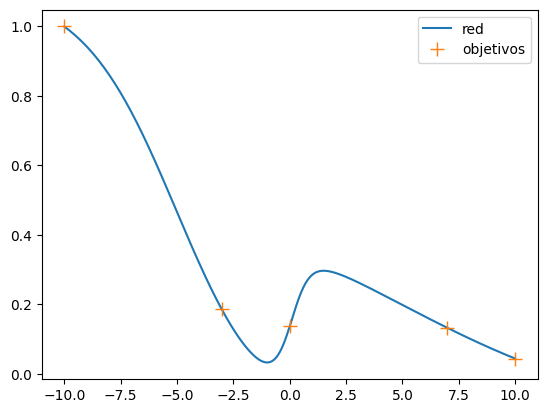

In [6]:
ygrafica = []
puntosGrafica = torch.linspace(min(valores),max(valores),250)
puntosGrafica = torch.linspace(-10,10,250)
for i in puntosGrafica:
    ytemp=red_rapida(torch.tensor([i],device = device))
    ygrafica.append(ytemp.detach().item())
    #ygrafica.append(ytemp.detach().numpy()[0])
import numpy as np
plt.plot(puntosGrafica,ygrafica, label = 'red')
plt.plot(valores,tiempos,linewidth = 0, marker = '+', ms = 10,label = 'objetivos')
plt.legend()

In [7]:
medioSpread = 10
minimo = 0
for i in range(6):
    puntosPrueba = torch.linspace(minimo - medioSpread,minimo+medioSpread,100)
    minimo = 0
    valor_minimo = 1e9
    for i in puntosPrueba:
        valor_actual = red_rapida(torch.tensor([i],device = device).float())
        if valor_actual < valor_minimo:
            minimo = i.item()
            valor_minimo = valor_actual
    medioSpread *= 0.1
print(minimo)
print(valor_minimo)

-1.0004699230194092
tensor([0.0326], device='cuda:0', grad_fn=<AddBackward0>)


In [13]:
def reversaso (x,min_x,max_x):
    x = x+10
    x = x/20
    x = x*(max_x-min_x)
    return x + min_x
reversaso(-3.01029996,min_valores,max_valores)    

def compresor_de_dominio(x_exp,y_exp):
    x_exp = np.log10(x_exp)
    x_exp = np.array(x_exp)
    max_x_exp = max(x_exp)
    min_x_exp = min(x_exp)
    x_exp = x_exp-min(x_exp)
    x_exp = x_exp/max(x_exp)*20-10
    y_exp = np.array(y_exp)/max(y_exp)
    return x_exp,y_exp,min_x_exp,max_x_exp


In [9]:
def optimizar_con_red (x_exp,y_exp):
    import numpy as np
    print(x_exp)
    red_rapida = NNRrapida().to(device)
    criterio = nn.MSELoss()
    optimizer = torch.optim.Adam(red_rapida.parameters(), lr=0.01)
    x_exp = np.log10(x_exp)
    x_exp = np.array(x_exp)
    max_x_exp = max(x_exp)
    min_x_exp = min(x_exp)
    x_exp = x_exp-min(x_exp)
    x_exp = x_exp/max(x_exp)*20-10
    y_exp = np.array(y_exp)/max(y_exp)
    print(f'puntos buscados en x : {x_exp}')
    print(f'puntos buscadoes en y : {y_exp}')
    # training loop:
    for _ in range(500):
        for i in range(len(x_exp)):
                x = torch.tensor([x_exp[i]],device = device,dtype=dtype)
                y = torch.tensor([y_exp[i]],device = device,dtype=dtype)
                optimizer.zero_grad()   # zero the gradient buffers
                output = red_rapida(x.float())
                loss = criterio(output, y.float())
                loss.backward()
                optimizer.step()    # Does the update
    ygrafica = []
    puntosGrafica = torch.linspace(min(x_exp),max(x_exp),250)
    puntosGrafica = torch.linspace(-10,10,250)
    for i in puntosGrafica:
        ytemp=red_rapida(torch.tensor([i],device = device))
        ygrafica.append(ytemp.detach().item())
        #ygrafica.append(ytemp.detach().numpy()[0])
    import numpy as np
    plt.plot(puntosGrafica,ygrafica, label = 'red')
    plt.plot(x_exp,y_exp,linewidth = 0, marker = '+', ms = 10,label = 'objetivos')
    plt.legend()
    medioSpread = 10
    minimo = 0
    # el siguiente loop encuentra el minimo dentro de la optimización.
    for i in range(6):
        puntosPrueba = torch.linspace(minimo - medioSpread,minimo+medioSpread,100)
        minimo = 0
        valor_minimo = 1e9
        for i in puntosPrueba:
            valor_actual = red_rapida(torch.tensor([i],device = device).float())
            if valor_actual < valor_minimo:
                minimo = i.item()
                valor_minimo = valor_actual
        medioSpread *= 0.1
    return minimo,medioSpread

In [10]:
valores = [2.84610043e-07,2.84610043e-07,7.45073742e-07,3.53553391e-06,1.67768629e-05,4.39197432e-05]
tiemposTomados = [1132.458431482315, 185.42029976844788, 164.9506914615631, 151.39227390289307, 88.37302136421204, 120.9418535232544]
valores = [2.84610043e-07,7.45073742e-07,3.53553391e-06,1.67768629e-05,4.39197432e-05]
tiemposTomados = [185.42029976844788, 164.9506914615631, 151.39227390289307, 88.37302136421204, 120.9418535232544]

valores = [2.84610043e-07,7.45073742e-07,3.53553391e-06,1.67768629e-05,4.39197432e-05]
tiemposTomados = [101.72396874427795, 55.661996364593506, 219.58437991142273, 48.8709876537323, 45.20528173446655]

[2.84610043e-07, 7.45073742e-07, 3.53553391e-06, 1.67768629e-05, 4.39197432e-05]
puntos buscados en x : [-1.00000000e+01 -6.18033989e+00  4.45467840e-09  6.18033990e+00
  1.00000000e+01]
puntos buscadoes en y : [0.46325685 0.25348796 1.         0.22256131 0.20586747]


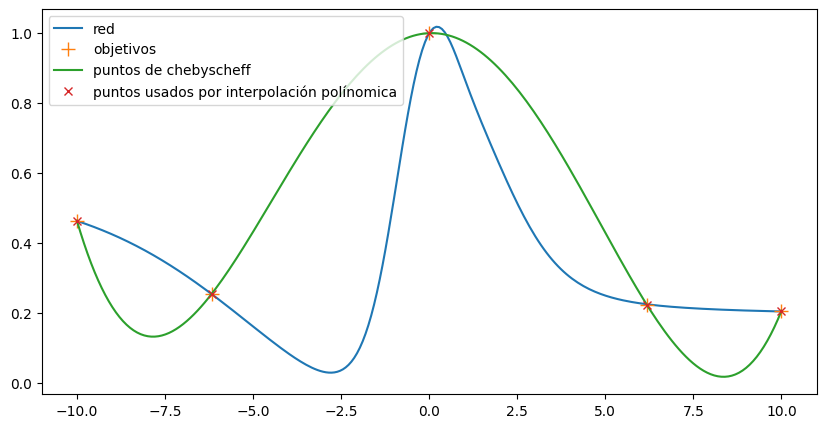

In [16]:
plt.figure(figsize = (10,5))
optimizar_con_red(valores,tiemposTomados)
x_comparación, y_comparación, in1,in2 = compresor_de_dominio(valores,tiemposTomados)
interpolacion = np.polynomial.Polynomial.fit(x_comparación,y_comparación,len(valores)-1)
x_grafica = np.linspace(-10,10,200)
plt.plot(x_grafica,interpolacion(x_grafica),label = 'puntos de chebyscheff')
plt.plot(x_comparación,y_comparación,label = 'puntos usados por interpolación polínomica',linewidth = 0, marker = 'x')
plt.legend()

In [15]:
import numpy as np
def descompresor_de_dominio (x,y,max_x,max_y):
    x = x*(max_x)
    x = 10**x
    return x,y*max_y
 

def compresor_de_dominio(x_exp,y_exp):
    max_y_exp = max(y_exp)
    x_exp = np.log10(x_exp)
    x_exp = np.array(x_exp)
    max_x_exp = max(x_exp)
    x_exp = x_exp/max_x_exp
    y_exp = np.array(y_exp)/max(y_exp)
    return x_exp,y_exp,min_x_exp,max_x_exp,max_y_exp

x = [1e-5,1e-4,1e-3]
y = [140,60,90]
x_exp,y_exp,min_x_exp,max_x_exp,max_y_exp = compresor_de_dominio(x,y)
compresor_de_dominio(x,y)

(array([1.66666667, 1.33333333, 1.        ]),
 array([1.        , 0.42857143, 0.64285714]),
 1e-05,
 -3.0,
 140)

In [16]:
descompresor_de_dominio(x_exp,y_exp,max_x_exp,max_y_exp)

(array([1.e-05, 1.e-04, 1.e-03]), array([140.,  60.,  90.]))